# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
from tqdm import tqdm_notebook

from helpers.normalization import normalize, denormalize, renormalize
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [16]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

# Functions

In [79]:
def hinge_loss(delta_true, delta_pred, threshold):
    """Finds the percentage of the time the prediction has the right sign
    """
    if isinstance(delta_true, dict):
        out = {}
        for k in delta_true.keys():
            if np.mean(np.abs(delta_true[k]))>threshold:
                out[k] = np.sum(np.maximum(np.sign(delta_true[k]*delta_pred[k]),0))/delta_true[k].size
            else:
                out[k] = np.nan
        return out
    if np.mean(np.abs(delta_true))>threshold:
        return np.sum(np.maximum(np.sign(delta_true*delta_pred),0))/delta_true.size
    else:
        return np.nan

def batch_hinge(model,generator,param_dict,sig):
    """Finds the percentage of the time the prediction has the right sign
    """    
    nbatches = len(generator)
    err = 0
    for ind in range(nbatches):
        inputs, targets = generator[ind]
        predictions = model.predict_on_batch(inputs)
        full_pred, full_true, delta_pred, delta_true, baseline = batch_denorm(inputs,targets,predictions,param_dict,sig)
        err += hinge_loss(delta_true,delta_pred)
    return err/nbatches    

def get_deltas(inputs, targets, profiles, predictions=None):
    delta_true = {}
    for profile in profiles:
        delta_true['target_' + profile] = targets['target_' + profile] - inputs['input_' + profile]
    if predictions is not None:
        delta_pred = {}
        for profile in profiles:
                delta_pred['target_' + profile] = predictions['target_' + profile] - inputs['input_' + profile]
        return delta_true, delta_pred
    else:
        return delta_true
                
                
                
                
def batch_denorm(inputs,targets,predictions,param_dict,sig):
    """Denormalizes and calculates deltas, prep for plotting and analysis
    """
    targets = targets['target_' + sig]
    baseline = inputs['input_' + sig][:,-1]
    predictions = predictions[sig]
    if predict_deltas:
        full_pred = predictions + baseline
        full_true = targets + baseline
    else:
        full_pred = predictions
        full_true = targets
    denorm_baseline = denormalize(baseline, param_dict[sig])
    denorm_full_pred = denormalize(full_pred, param_dict[sig])
    denorm_full_true = denormalize(full_true, param_dict[sig])
    denorm_delta_pred = denorm_full_pred - denorm_baseline
    denorm_delta_true = denorm_full_true - denorm_baseline
    return denorm_full_pred, denorm_full_true, denorm_delta_pred, denorm_delta_true, denorm_baseline

def plot_batch(y_true, y_pred, baseline, psi, labels, axlabels,shots,times):
    batch_size = y_true.shape[0]
    ncols = 4
    nrows = int(batch_size/ncols)
    figsize = (20,10*batch_size/10)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # Plot predictions and true deltas
    for i in range(batch_size):
        ax[i].plot(psi,y_true[i], label=labels[0])
        ax[i].plot(psi,y_pred[i], label=labels[1])
        ax[i].plot(psi,baseline[i], label=labels[2])
        ax[i].title.set_text('Shot ' + str(int(shots[i])) + ', time ' + str(int(times[i])))
        ax[i].set_xlabel(axlabels[0])
        ax[i].set_ylabel(axlabels[1])
        ax[i].set_ylim(-2*normalization_params[sig]['std'],2*normalization_params[sig]['std'])
        ax[i].legend(loc=0)
    plt.tight_layout()
    return fig,ax

def set_future_actuators(inputs, actuator_names, change):
    for sig in actuator_names:
        inputs['input_future_' + sig][:] = inputs['input_past_' + sig][:,-1] + change
    return inputs

# Load Model & Get Data

In [6]:
file_path = os.path.expanduser("~/run_results_11_2/model-conv1d_profiles-temp-dens-press_EFIT01-ffprime_EFIT01-q_EFIT01_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_03Nov19-01-54.h5")
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
     analysis_params = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(analysis_params.keys()))


loaded model: model-conv1d_profiles-temp-dens-press_EFIT01-ffprime_EFIT01-q_EFIT01_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_03Nov19-01-54.h5
loaded dict: model-conv1d_profiles-temp-dens-press_EFIT01-ffprime_EFIT01-q_EFIT01_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_03Nov19-01-54_params.pkl
with parameters: dict_keys(['actuator_names', 'input_profile_names', 'target_profile_names', 'scalar_input_names', 'profile_downsample', 'model_type', 'model_kwargs', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'batch_size', 'epochs', 'flattop_only', 'predict_deltas', 'raw_data_path', 'process_data', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'u

In [10]:
analysis_params['history'].keys()

dict_keys(['val_loss', 'val_target_temp_loss', 'val_target_dens_loss', 'val_target_temp_denorm_MAE', 'val_target_temp_sgn_acc', 'val_target_temp_perBLMAE', 'val_target_dens_denorm_MAE', 'val_target_dens_sgn_acc', 'val_target_dens_perBLMAE', 'loss', 'target_temp_loss', 'target_dens_loss', 'target_temp_denorm_MAE', 'target_temp_sgn_acc', 'target_temp_perBLMAE', 'target_dens_denorm_MAE', 'target_dens_sgn_acc', 'target_dens_perBLMAE', 'lr'])

In [12]:
model.outputs

[<tf.Tensor 'target_temp_1/Reshape:0' shape=(?, 33) dtype=float32>,
 <tf.Tensor 'target_dens_1/Reshape:0' shape=(?, 33) dtype=float32>]

In [13]:
analysis_params['target_profile_names']

['temp', 'dens']

In [18]:
def plot_conv_training(model,analysis_params,filename=None,**kwargs):
    
    font={'family': 'DejaVu Serif',
      'size': 18}
    plt.rc('font', **font)
    matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

    targets = analysis_params['target_profile_names']
    nout = len(targets)
    nrows = int(np.ceil((nout+1)/2))
    f, axes = plt.subplots(nrows, 2, figsize=(28, 14*nrows))
    axes[0,0].semilogy(analysis_params['history']['loss'],label='train')
    axes[0,0].semilogy(analysis_params['history']['val_loss'],label='val')
    axes[0,0].set_title('Loss')
    axes[0,0].legend()
    i=1
    for i,targ in enumerate(targets):
        idx = np.unravel_index(i+1,(nrows,2))
        if 'target_' + targ + '_mean_squared_error' in analysis_params['history'].keys():
            axes[idx].semilogy(analysis_params['history']['target_' + targ + '_mean_squared_error'],label='train')
            axes[idx].semilogy(analysis_params['history']['val_target_' + targ + '_mean_squared_error'],label='val')
            axes[idx].set_title(targ + ' MSE')
            axes[idx].legend()
        else:
            axes[idx].semilogy(analysis_params['history']['target_' + targ + '_loss'],label='train')
            axes[idx].semilogy(analysis_params['history']['val_target_' + targ + '_loss'],label='val')
            axes[idx].set_title(targ + ' loss')
            axes[idx].legend()
    
    if filename:
        f.savefig(filename,bbox_inches='tight',quality=25)
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

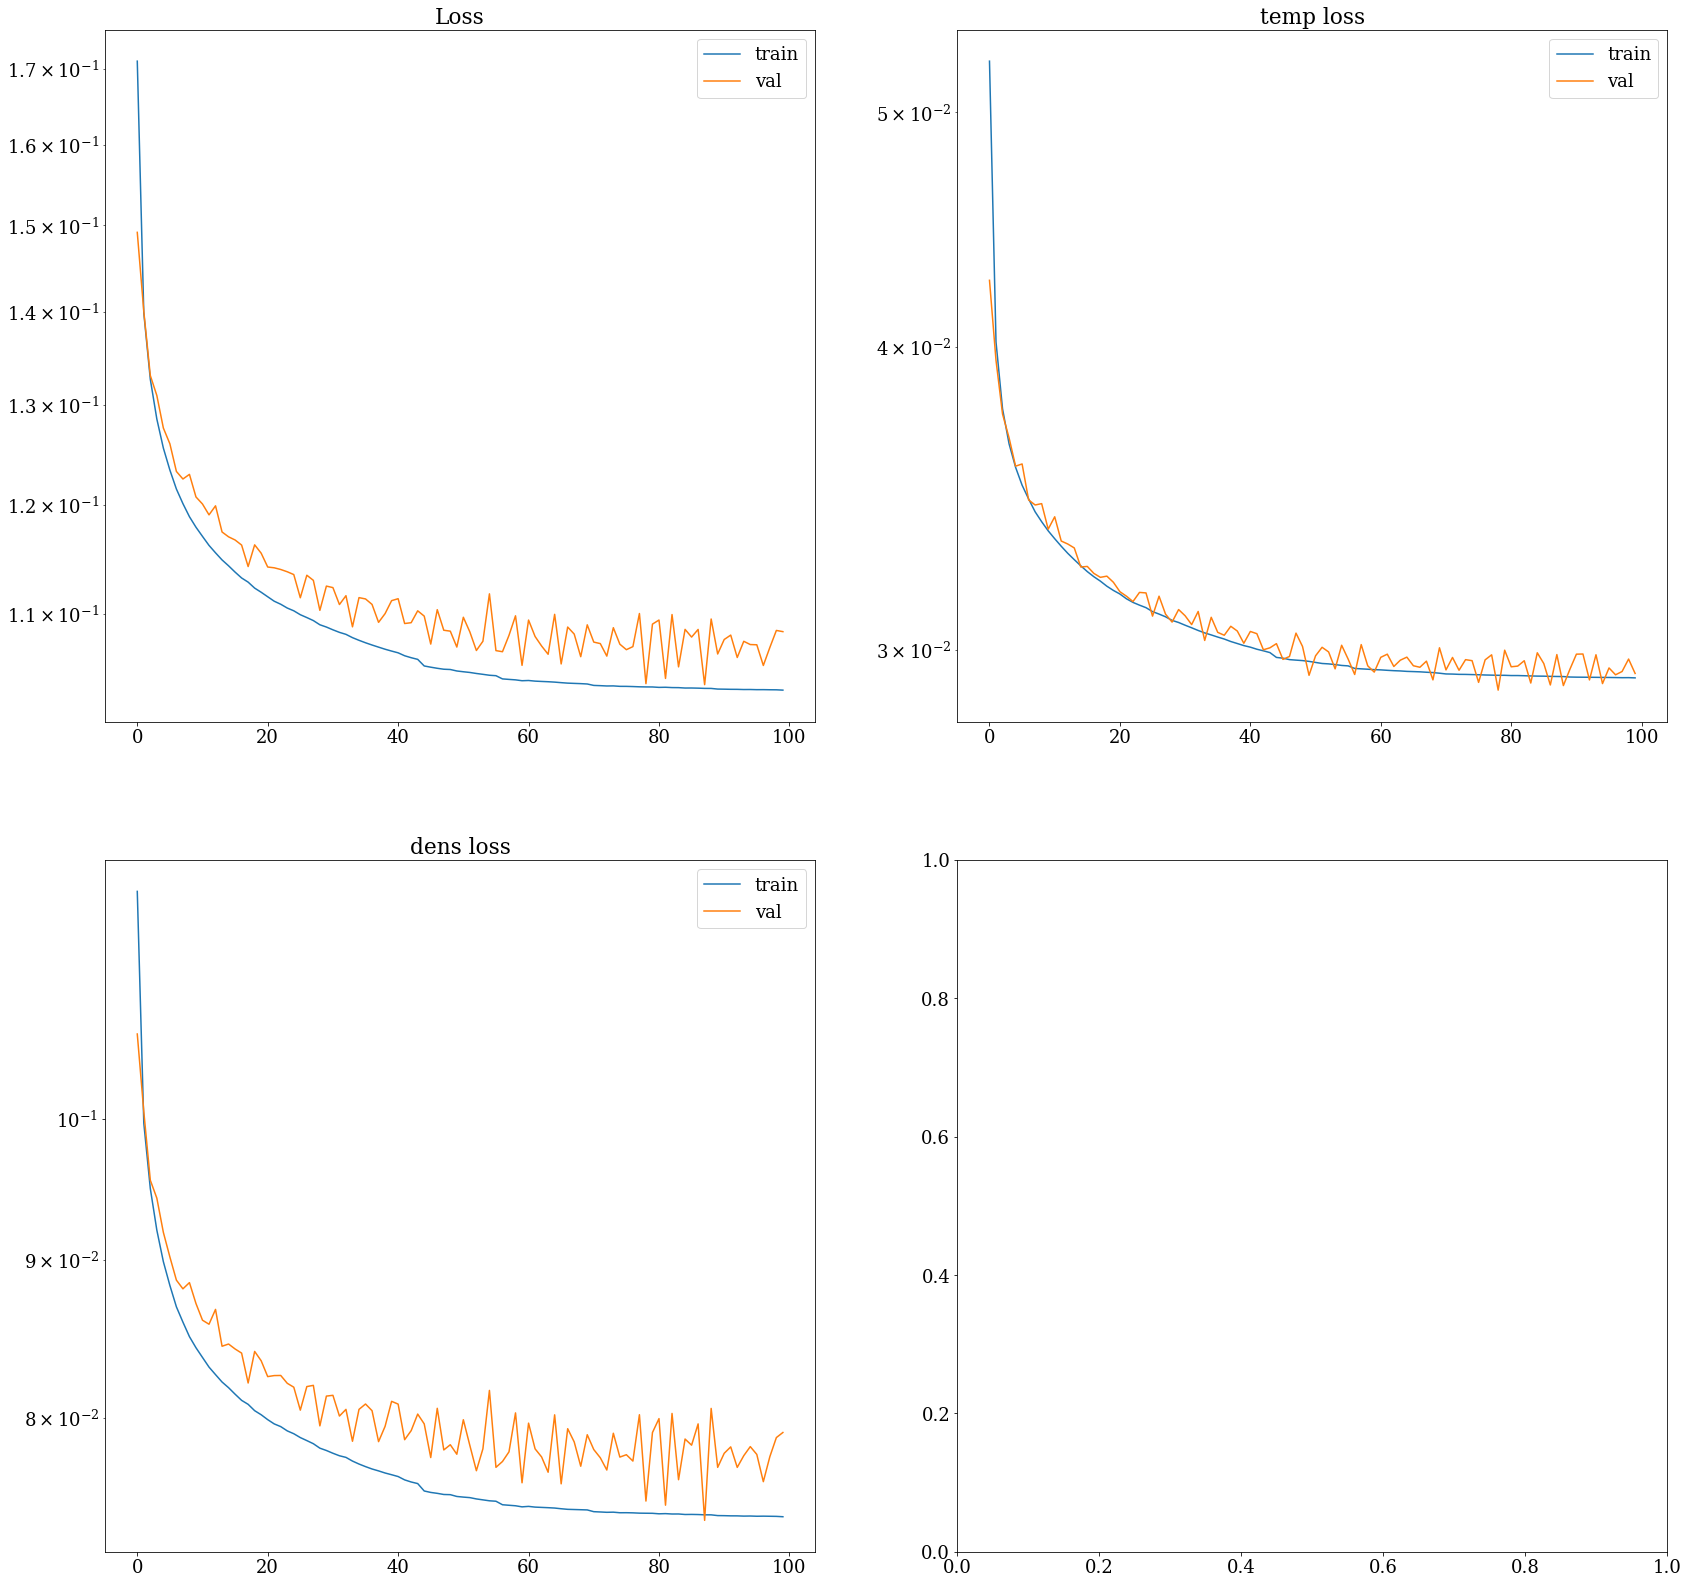

In [19]:
f = plot_conv_training(model,analysis_params)

In [30]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

def write_conv_results(scenario,model):
    """opens a google sheet and writes results, and generates images and html"""

    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    
    base_sheet_path = "https://docs.google.com/spreadsheets/d/10ImJmFpVGYwE-3AsJxiqt0SyTDBCimcOh35au6qsh_k/edit#gid=0"
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
    client = gspread.authorize(creds)
    sheet = client.open_by_url(base_sheet_path).sheet1
    
    write_scenario_to_sheets(scenario,sheet)
    rowid = sheet.find(analysis_params['runname']).row
    scenario['sheet_path'] = base_sheet_path + "&range={}:{}".format(rowid,rowid)
    
    results_dir =os.path.expanduser('~/plasma-profile-predictor/results/'+scenario['runname'])  
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    os.chdir(results_dir)
    f = open('index.html','w+')
    f.write('<html><head></head><body>')
    html = scenario_to_html(scenario)
    f.write(html + '<p>\n')
    _, html = plot_conv_training(model,scenario, filename='training.png')
    f.write(html + '<p>\n')
 
    f.write('</body></html>')
    f.close()
    
    
def write_scenario_to_sheets(scenario,sheet):
    sheet_keys = sheet.row_values(1)
    row = [None]*len(sheet_keys)
    for i,key in enumerate(sheet_keys):
        if key in scenario.keys():
            row[i] = str(scenario[key])
        elif key in scenario.get('history',{}):
            row[i] = str(scenario['history'][key][-1])
    sheet.append_row(row)

def scenario_to_html(scenario):
    foo = {k:v for k,v in scenario.items() if k not in ['history','normalization_dict','history_params']}
    def printitems(dictObj, indent=0):
        p=[]
        p.append('<ul>\n')
        for k,v in dictObj.items():
            if isinstance(v, dict):
                p.append('<li><b>'+ str(k)+ '</b>: ')
                p.append(printitems(v))
                p.append('</li>\n')
            elif k in ['image_path','sheet_path']:
                p.append("<a href=\"" + str(v) + "\">" + str(k) + "</a>\n")          
            else:
                p.append('<li><b>'+ str(k)+ '</b>: '+ str(v)+ '</li>\n')
        p.append('</ul>\n')
        return ''.join(p)
    return printitems(foo)

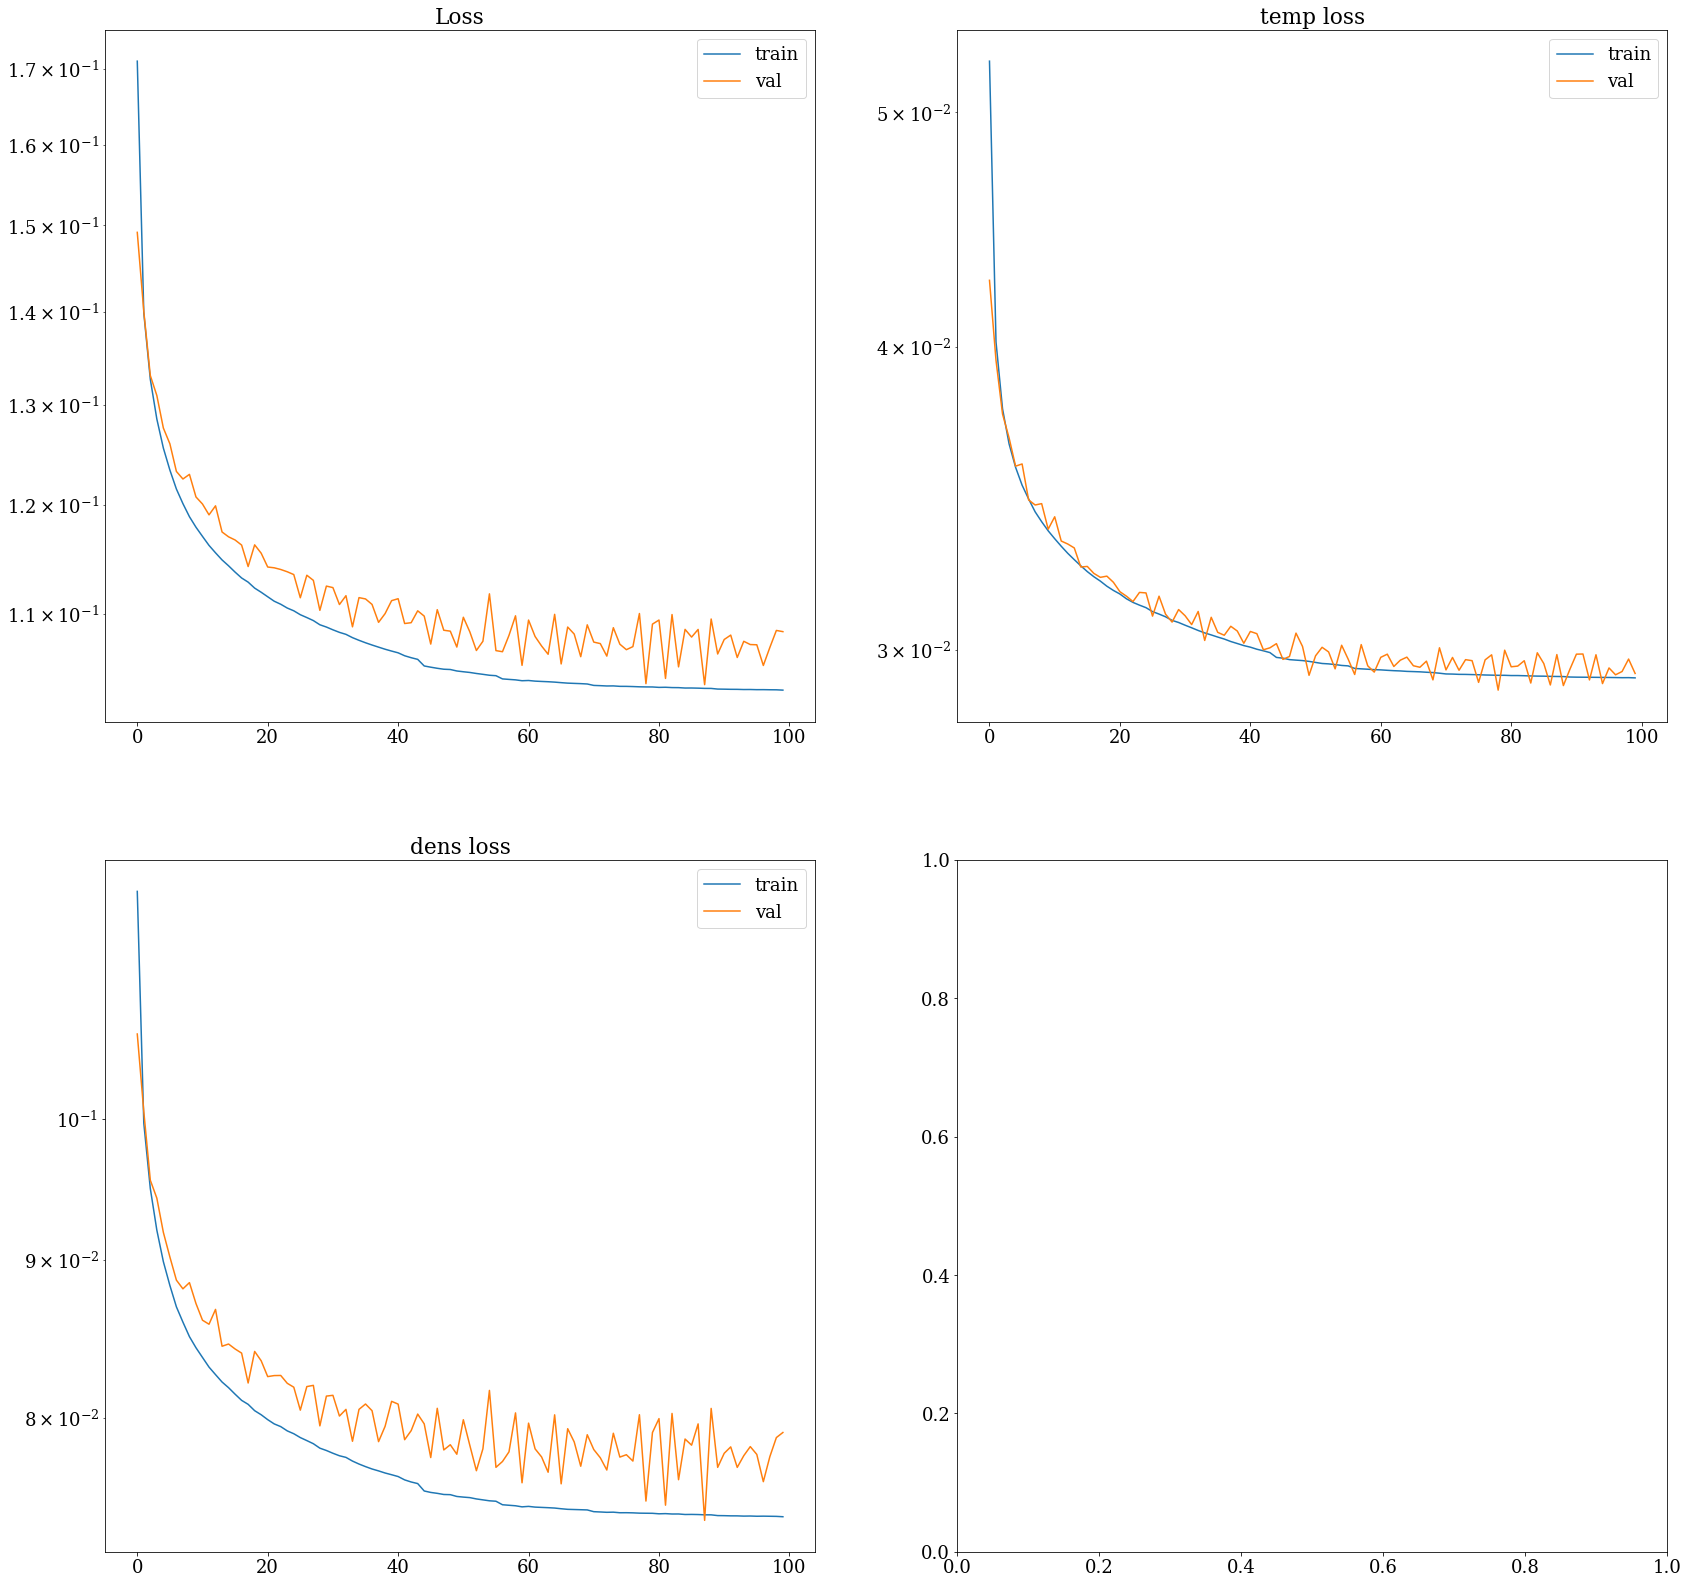

In [31]:
write_conv_results(analysis_params,model)

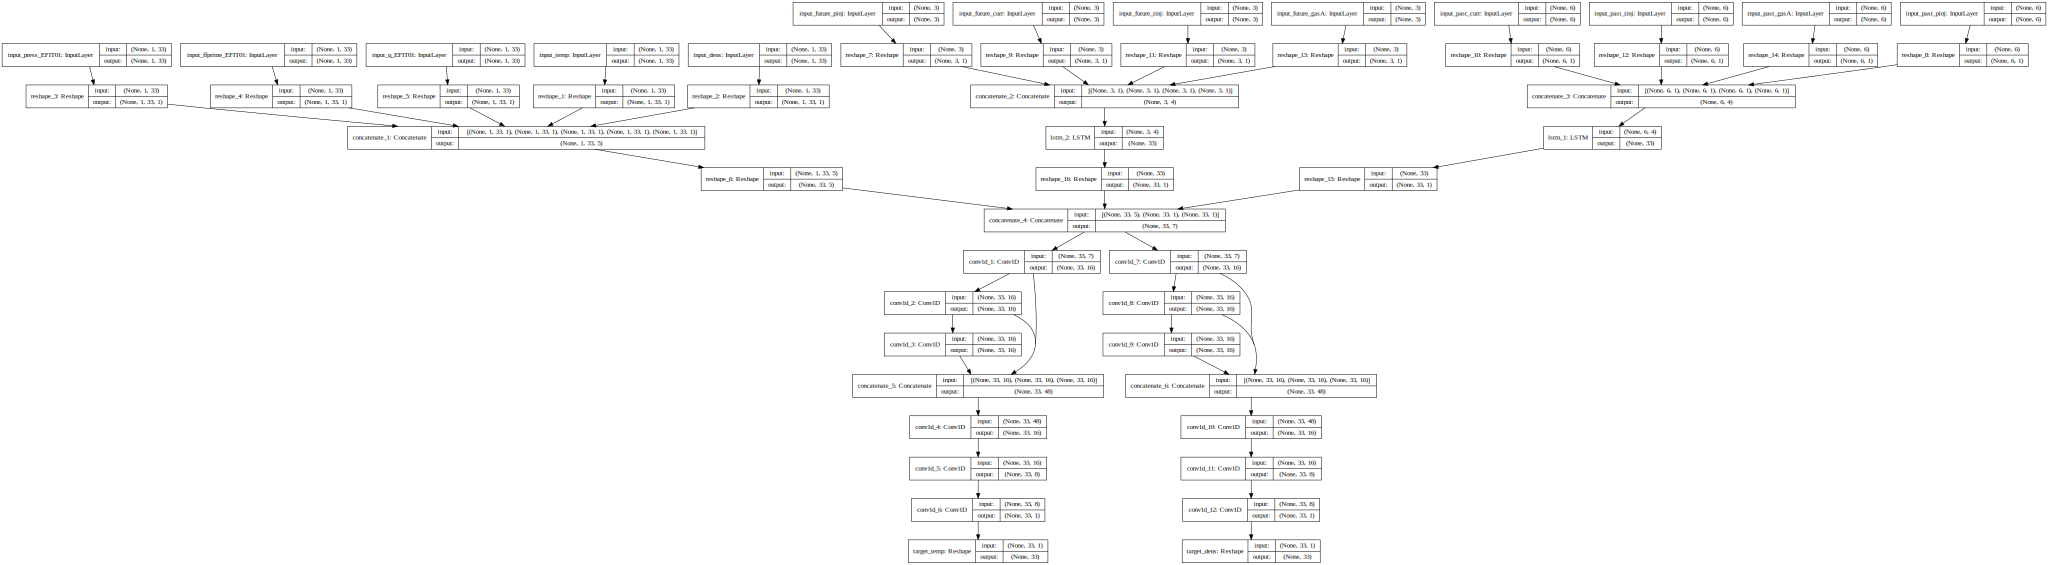

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB').create(prog='dot', format='svg'))

# Sensitivity Analysis

In [ ]:
shots = [173649]
times = [6000]
inputs, targets = train_generator.get_data_by_shot_time(shots,times)
input_const = set_future_actuators(inputs, actuator_names, 0)
pred_const = model.predict_on_batch(input_const)
input_increasing = set_future_actuators(inputs, actuator_names, 0.5)
pred_increasing = model.predict_on_batch(input_increasing)
input_decreasing = set_future_actuators(inputs, actuator_names, -0.5)
pred_decreasing = model.predict_on_batch(input_decreasing)

In [ ]:
inputs['input_past_pinj']

# Full Run Processing

In [65]:
base_path = os.path.expanduser('~/run_results/')
files = os.listdir(base_path)
model_files = [file for file in files if 'h5' in file]
param_files = [file[:-3] + '_params.pkl' for file in model_files]
num_models = len(model_files)
print('number of models: ' + str(num_models))

number of models: 102


In [66]:
models = []
params = []
for modelname, paramsname in tqdm_notebook(zip(model_files,param_files), total=num_models):
    models.append(keras.models.load_model(base_path+modelname, compile=False))
    with open(base_path+paramsname, 'rb') as f:
         params.append(pickle.load(f, encoding='latin1'))

In [91]:
sign_acc = {'temp': [], 'dens':[]}
threshold = .1
ftop_filepath_base = '/scratch/gpfs/jabbate/data_60_ms_randomized_flattop/'
for model, scenario in tqdm_notebook(zip(models,params), total=num_models, position=0):
    with open(os.path.join(ftop_filepath_base, 'val.pkl'), 'rb') as f:
        valdata = pickle.load(f)
    val_generator = DataGenerator(valdata,
                                  1,
                                  scenario['input_profile_names'],
                                  scenario['actuator_names'],
                                  scenario['target_profile_names'],
                                  scenario['scalar_input_names'],
                                  scenario['lookbacks'],
                                  scenario['lookahead'],
                                  scenario['predict_deltas'],
                                  scenario['profile_downsample'],
                                  scenario['shuffle_generators'])
    temp_sign_acc = []
    dens_sign_acc = []
    for i in tqdm_notebook(range(int(len(val_generator)/100)), position=1, leave=False):
        inputs, targets = val_generator[i]
        pred = model.predict_on_batch(inputs)
        predictions = {}
        for i, sig in enumerate(scenario['target_profile_names']):
            predictions['target_'+sig] = pred[i]
        if not scenario['predict_deltas']:
            delta_true, delta_pred = get_deltas(inputs, targets, scenario['target_profile_names'], predictions)
        else:
            delta_true = targets
            delta_pred = predictions
        foo = hinge_loss(delta_true,delta_pred, threshold)
        temp_sign_acc.append(foo['target_temp'])
        dens_sign_acc.append(foo['target_dens'])
    sign_acc['temp'].append(np.nanmean(temp_sign_acc))
    sign_acc['dens'].append(np.nanmean(dens_sign_acc))

        
        
    
    
    

In [94]:
np.max(sign_acc['dens'])

0.7975265475265475

In [95]:
np.argmax(sign_acc['dens'])

12

In [ ]:

sensitivity = []
ftop_filepath_base = '/scratch/gpfs/jabbate/data_60_ms_randomized_flattop/'
for model, scenario in tqdm_notebook(zip(models,params), total=num_models, position=0):
    with open(os.path.join(ftop_filepath_base, 'val.pkl'), 'rb') as f:
        valdata = pickle.load(f)
    val_generator = DataGenerator(valdata,
                                  1,
                                  scenario['input_profile_names'],
                                  scenario['actuator_names'],
                                  scenario['target_profile_names'],
                                  scenario['scalar_input_names'],
                                  scenario['lookbacks'],
                                  scenario['lookahead'],
                                  scenario['predict_deltas'],
                                  scenario['profile_downsample'],
                                  scenario['shuffle_generators'])
    delta_actuators = [-1.5, -1, -.5, 0, .5, 1, 1.5]
    predictions_pert = {sig: {act:{d:[] for d in delta_actuators} for act in scenario['actuator_names']} for sig in scenario['target_profile_names']}
    for i in tqdm_notebook(range(int(len(val_generator)/100)), position=1, leave=False):
        inputs, targets = val_generator[i]
        input_const = set_future_actuators(inputs, scenario['actuator_names'], 0)
        pred_const = model.predict_on_batch(input_const)
        predictions_const = {}
        for i, sig in enumerate(scenario['target_profile_names']):
            predictions_const[sig] = pred_const[i]
        for act in scenario['actuator_names']:
            for d in delta_actuators:
                input_pert = set_future_actuators(input_const, [act], d)
                pred_pert = model.predict_on_batch(input_pert)
                for i, sig in enumerate(scenario['target_profile_names']):
                    predictions_pert[sig][act][d].append(np.mean(pred_pert[i] - predictions_const[sig], axis=-1))
    for sig in scenario['target_profile_names']:
        for act in scenario['actuator_names']:
            for d in delta_actuators:
                predictions_pert[sig][act][d] = {'mean': np.mean(predictions_pert[sig][act][d]),'std': np.std(predictions_pert[sig][act][d])}
    sensitivity.append(predictions_pert) 
    


In [67]:
scenarios = [int(foo.split('_')[-1].split('-')[-1].split('.')[0]) for foo in model_files]

# Plot Predictions vs True

In [ ]:
sig='itemp'
all_means=[]
all_stds=[]
for shot in data.keys():
    if sig in data[shot]:
        data[shot][sig][np.isinf(data[shot][sig])] = np.nan
        this_mean=np.nanmean(data[shot][sig])
        this_std=np.nanstd(data[shot][sig])
        if False: #abs(this_mean)>4000:
            print(shot)
            print(np.mean(all_means))
            print(this_mean)
            print('\n')
            print(np.std(all_stds))
            print(this_std)
            print('\n')
        else:
            all_means.append(this_mean)
            all_stds.append(this_std)
plt.hist(all_means)

In [ ]:
shots=list(data.keys())
shot=np.random.choice(shots)
plt.plot(data[shot]['curr_target'])
inds=np.where(np.isclose(data[shot]['curr_target'],max(data[shot]['curr_target'])))[0]
plt.axvline(inds[0])
plt.axvline(inds[-1])
plt.show()

In [ ]:
analysis_params['batch_size']=1
train_generator = DataGenerator(traindata,**analysis_params)
steps_per_epoch = len(train_generator)

In [ ]:
batch_ind+=1
inputs, targets = train_generator[batch_ind]
shotnums = train_generator.cur_shotnum[:,max(profile_lookback, actuator_lookback)]
times = train_generator.cur_times[:,max(profile_lookback, actuator_lookback)]
pred = model.predict_on_batch(inputs)
# # add deltas to future actuators
# #predict on new actuators
# predictions = {}
# for i, sig in enumerate(target_profile_names):
#     predictions[sig] = pred[i]
# psi = np.linspace(0,1,profile_length)
# full_pred = {}
# full_true = {}
# delta_pred = {}
# delta_true = {}
# baseline = {}
# for sig in target_profile_names:
#     full_pred[sig], full_true[sig], delta_pred[sig], delta_true[sig], baseline[sig] = batch_denorm(inputs,targets,predictions,
#                                                                                                    normalization_params,sig)

# Design your own shot

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]

In [ ]:
all_shots=np.unique(traindata['shotnum'])
shotnum=np.random.choice(all_shots) #all_shots[5]
t=4700

psi = np.linspace(0,1,profile_length)
sigs=['curr','pinj','tinj','gasA','temp','dens']
profiles=['temp','dens']
input_profiles=['thomson_temp_EFITRT1','thomson_dens_EFITRT1']
changed_input_keys=['pinj']
changed_profile_keys=[] #'thomson_dens_EFITRT1']

shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]

time_offset=np.searchsorted(traindata['time'][shot_indices,-lookahead],t)


#prev_targets=train_generator[shot_indices[0]+time_offset-1][1]

inputs=train_generator[shot_indices[0]+time_offset][0]

changed_input=copy.deepcopy(inputs)
for key in changed_input_keys:
    #changed_input['input_past_{}'.format(key)]=np.array([np.linspace(-2,0,actuator_lookback)])
    #changed_input['input_future_{}'.format(key)]-=[0,.5,1,1.5]
    
    prev=traindata[key][shot_indices[0]+time_offset][-lookahead]
    changed_input['input_future_{}'.format(key)]=np.array([[prev]*lookahead])
    changed_input['input_future_{}'.format(key)]=np.array([np.linspace(prev,prev-2,lookahead)]) 
    #prev=traindata[key][shot_indices[0]+time_offset][-1]#0]
    #changed_input['input_past_{}'.format(key)]=np.array([[prev]*actuator_lookback])

for key in changed_profile_keys:
    #changed_input['input_{}'.format(key)]=np.array([[[0]*profile_length]])
    changed_input['input_{}'.format(key)]-=np.array([[np.linspace(0,1,profile_length)]])
    
targets=train_generator[shot_indices[0]+time_offset][1]

num_cols=4

fig=plt.figure()
for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),num_cols,i*num_cols+1)
    if len(traindata[sig][shot_indices].shape)>2:
        ax.plot(traindata['time'][shot_indices,-lookahead],
                np.mean(traindata[sig][shot_indices,-lookahead,:],axis=1),
                c='b')
#         ax.contourf(traindata['time'][shot_indices,-lookahead],
#                 psi,
#                 traindata[sig][shot_indices,-lookahead,::analysis_params['profile_downsample']].T)
        ax.set_ylim(-2,2)
        
    else:
        ax.plot(traindata['time'][shot_indices[0],:-lookahead],
                        traindata[sig][shot_indices[0],:-lookahead],
               c='b')
        ax.plot(traindata['time'][shot_indices,-lookahead],
                        traindata[sig][shot_indices,-lookahead],
               c='b')
        if sig in changed_input_keys:
            ax.plot(traindata['time'][shot_indices[0]+time_offset,-lookahead:],
                   changed_input['input_future_{}'.format(sig)].squeeze(),
                   color='r')
            ax.plot(traindata['time'][shot_indices[0]+time_offset,:-lookahead],
                   changed_input['input_past_{}'.format(sig)].squeeze(),
                   color='r')
        if sig=='curr':
            ax.set_ylim(-6,6)
            N=1
            smoothed=np.convolve(traindata[sig][shot_indices,-lookahead], np.ones((N,))/N, mode='valid') 
            #smoothed=traindata[sig][shot_indices,-lookahead][::N]
            #flattop_start_ind=np.where(np.isclose(np.diff(smoothed),0,atol=2e-3))[0][0]
            flattop_inds=np.where(np.isclose(smoothed,np.max(smoothed),atol=1e-3))[0]
            ax.axvline(traindata['time'][flattop_inds[0],-lookahead],linewidth=4)
            ax.axvline(traindata['time'][flattop_inds[-1],-lookahead],linewidth=4)
        else:
            ax.set_ylim(-2,2)
        
    
    ax.axvline(traindata['time'][shot_indices[0]+time_offset,-lookahead],
              color='r')
    ax.axvline(traindata['time'][shot_indices[0]+time_offset,-1],
              color='g')
    ax.axvline(traindata['time'][shot_indices[0]+time_offset,0],
              color='k')
    ax.set_xlim(0,np.amax(traindata['time'][shot_indices]))
    ax.set_title(sig)

# truths=train_generator[shot_indices[0]+time_offset][1]

for i,profile in enumerate(input_profiles):
    ax=fig.add_subplot(len(input_profiles),num_cols,i*num_cols+1+1)
    
    ax.plot(psi,inputs['input_{}'.format(profile)].squeeze(),c='g')
    if profile in changed_profile_keys:
        ax.plot(psi,changed_input['input_{}'.format(profile)].squeeze(),c='r')
    ax.set_title('{}'.format(profile))
    ax.axhline(0,color='k',alpha=.5)
    ax.set_ylim(-2,2)

predictions=model.predict_on_batch(inputs)
changed_predictions=model.predict_on_batch(changed_input)
for i,profile in enumerate(profiles):
    ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1+1)
    ax.plot(psi,targets['target_{}'.format(profile)].squeeze(),label='True',c='g')
    ax.plot(psi,predictions[i].squeeze(),label='Prediction',
            c='b')
    ax.plot(psi,changed_predictions[i].squeeze(),color='r',label='Perturbed Prediction')
    ax.set_title('{} change'.format(profile))
    ax.axhline(0,color='k',alpha=.5)
    ax.set_ylim(-2,2)
    ax.legend()
    
    ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1+1+1)
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][0][::analysis_params['profile_downsample']],
            label='Previous',
            c='k')
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][-1][::analysis_params['profile_downsample']],
            label='Next',
            c='g')
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][0][::analysis_params['profile_downsample']]+predictions[i].squeeze(),
            label='Prediction',
            c='b')
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][0][::analysis_params['profile_downsample']]+changed_predictions[i].squeeze(),
            label='Perturbed Prediction',
            c='r')
    ax.legend()
    ax.set_title(profile)
    ax.set_ylim(-2,2)
    ax.axhline(0,color='k',alpha=.5)
    
time=train_generator.cur_times[:,max(profile_lookback, actuator_lookback)].squeeze()
fig.suptitle('Shot {:.0f}, {:.0f} ms'.format(shotnum,time),fontsize=30)
plt.subplots_adjust(hspace=.2)
plt.show()

In [ ]:
sig = 'temp'
fig, ax = plot_batch(full_true[sig],full_pred[sig],baseline[sig],
                     psi,['true','pred','baseline'],['psi',sig], shotnums,times)  

In [ ]:
sig = 'dens'
fig, ax = plot_batch(full_true[sig],full_pred[sig],baseline[sig],
                     psi,['true','pred','baseline'],['psi',sig], shotnums,times)  

In [ ]:
sig = 'press'
fig, ax = plot_batch(full_true[sig],full_pred[sig],baseline[sig],
                     psi,['true','pred','baseline'],['psi',sig], shotnums,times)  